In [195]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, IntegerType
from pyspark.ml.classification import RandomForestClassifier
from difflib import unified_diff
import pyspark.sql.functions as F
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os
from difflib import unified_diff

In [196]:
path = '/home/edoardo/Desktop/University/KU Leuven/Advancedanalytics/ThirdAssignment/output'

In [197]:
def make_diff(old, new):
    return '\n'.join([l for l in unified_diff(old.split('\n'), new.split('\n')) if l.startswith('+') or l.startswith('-')])

In [198]:
def accuracy_m(model): 
    predictions = model.transform(test)
    cm = predictions.select("newlabel", "prediction")
    acc = cm.filter(cm.newlabel == cm.prediction).count() / cm.count()
    print("Model accuracy: %.3f%%" % (acc * 100)) 

In [200]:
def save_streaming_dataset():
    for d in os.listdir(f"{path}/vandals")[:1]:
        tot_df = pd.read_csv(f"{path}/vandals/{d}/df.csv", index_col=0, sep="|")

    for d in os.listdir(f"{path}/vandals")[1:]:
        df = pd.read_csv(f"{path}/vandals/{d}/df.csv", index_col=0, sep="|")
        tot_df = pd.concat([tot_df, df]).reset_index(drop=True)

    for d in os.listdir(f"{path}/mixed"):
        df = pd.read_csv(f"{path}/mixed/{d}/df.csv", index_col=0, sep="|")
        tot_df = pd.concat([tot_df, df]).reset_index(drop=True)

    tot_df['text_old'] = tot_df['text_old'].str.replace("|", "-")
    tot_df['text_old'] = tot_df['text_old'].str.replace("\n", " ")
    tot_df['text_new'] = tot_df['text_new'].str.replace("|", "-")
    tot_df['text_new'] = tot_df['text_new'].str.replace("\n", " ")
    tot_df['comment'] = tot_df['comment'].str.replace("|", "-")
    tot_df['comment'] = tot_df['comment'].str.replace("\n", " ")
    tot_df['name_user'] = tot_df['name_user'].str.replace("|", "-")
    tot_df['name_user'] = tot_df['name_user'].str.replace("\n", " ")
    tot_df.loc[:, ['text_old', 'text_new', 'name_user', 'comment', 'label']].to_csv(
        f"{path}/final_df.csv", sep="|", index=False)
    print(f"number of datapoints: {len(tot_df)}")

In [201]:
# put together data
save_streaming_dataset()

number of datapoints: 2268


In [207]:
# load dataset
schema = StructType([
    StructField("text_old", StringType(), True),
    StructField("text_new", StringType(), True),
    StructField("name_user", StringType(), True),
    StructField("comment", StringType(), True),
    StructField("label", StringType(), True)])

df = spark.read.csv(f"{path}/final_df.csv", sep='|', header=True, mode='PERMISSIVE', schema=schema)

In [208]:
# preprocessing
diff_udf = F.udf(make_diff, StringType())
df_withdiff = df.withColumn("diff", diff_udf(F.col("text_old"), F.col("text_new")))
df_withip = df_withdiff.withColumn("ip", F.when((F.size(F.split(F.col("name_user"), r"\.")) - 1) == 4, 1)
                                           .when((F.size(F.split(F.col("name_user"), r"\:")) - 1) == 7, 1)
                                           .otherwise(0))
df_nanComment = df_withip.withColumn("nan_comment", F.when(F.isnan(F.col("comment")) | F.isnull(F.col("comment")), 1)
                                    .otherwise(0))
df = df_nanComment.select(['diff', 'ip', 'nan_comment', 'label'])

In [209]:
# split
train, test = df.randomSplit([0.8, 0.2], seed = 2018)

In [210]:
# pipeline
tokenizer = Tokenizer(inputCol="diff", outputCol="words")
stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="stopw")
hashingTF = HashingTF(inputCol="stopw", outputCol="rawFeatures", numFeatures=200)
idf = IDF(inputCol="rawFeatures", outputCol="rawfeaturesidf")
assembler = VectorAssembler(inputCols=["rawfeaturesidf", "ip", "nan_comment"], outputCol="features")
label_encoder = StringIndexer(inputCol="label", outputCol="newlabel")

In [211]:
# fitting
stages = [tokenizer, stopWordsRemover, hashingTF, idf, assembler, label_encoder]
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

In [212]:
# logistic regression
lr = LogisticRegression(featuresCol='features', labelCol='newlabel', maxIter=100)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
accuracy_m(lrModel)

Model accuracy: 75.372%


In [213]:
# classification report
y_true = predictions.select(['newlabel']).collect()
y_pred = predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       353
         1.0       0.42      0.26      0.32        66
         2.0       0.30      0.25      0.27        52

    accuracy                           0.75       471
   macro avg       0.52      0.48      0.49       471
weighted avg       0.72      0.75      0.73       471



[Text(0, 0.5, 'safe'), Text(0, 1.5, 'unsafe'), Text(0, 2.5, 'vandal')]

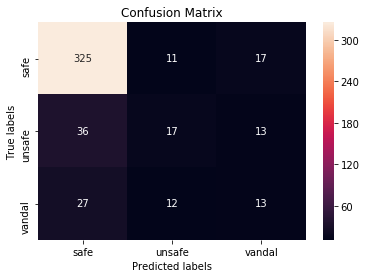

In [214]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt  

cm = confusion_matrix(y_true, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,  fmt='g') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['safe', 'unsafe', 'vandal'])
ax.yaxis.set_ticklabels(['safe', 'unsafe', 'vandal'])

In [ ]:
# to try this model we need more data
rf = RandomForestClassifier(featuresCol='features', labelCol='newlabel', numTrees=50)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
accuracy_m(rfModel)

In [215]:
# pipeline
tokenizer = Tokenizer(inputCol="diff", outputCol="words")
stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="stopw")
hashingTF = HashingTF(inputCol="stopw", outputCol="rawFeatures", numFeatures=200)
idf = IDF(inputCol="rawFeatures", outputCol="rawfeaturesidf")
assembler = VectorAssembler(inputCols=["rawfeaturesidf", "ip", "nan_comment"], outputCol="features")
label_encoder = StringIndexer(inputCol="label", outputCol="newlabel")

In [216]:
# saving model
stages = [tokenizer, stopWordsRemover, hashingTF, idf, assembler, label_encoder, lr]
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
pipelineModel.save(f"{path}/pipelineModel")